In [1]:
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset

/users/ansaripo/miniconda3/envs/robots/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
data = pd.read_csv('data/news_factor.csv')

print(data.loc[0, 'full_prefix'])
print(data.loc[0, 'completion'])
print(data.loc[0, 'contradiction_0'])
print(data.loc[0, 'contradiction_1'])
print(data.loc[0, 'contradiction_2'])

As streaming television services continue to gain market share, there are a number of reasons why Netflix might be in trouble. Time Warner is taking its HBO content online, Amazon offers premium content for a monthly fee, and Hulu has reached nine million users. While these competitors may cause a bit of worry, it’s not the end of the world. Although Netflix has a huge amount of potential, the increased competition is unlikely to hurt its profitability.
While the global pandemic last year caused a major shakeup in Hollywood, Netflix should not rest on its laurels. With a variety of rivals on the rise, it’s unlikely that it can continue to rely on its current performance. Despite the competition, the company has made a number of impactful moves across the board, including clamping down on password sharing. And in the coming years, Netflix should continue to grow and compete with new competitors.
With more competitors entering the streaming space, Netflix is likely to face a more difficu

In [1]:
import argparse
import os

import numpy as np
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

# load data
def extract_example(row):
    return {'full_prefix': row.full_prefix, 'completion': row.completion,
            'contradictions': [row.contradiction_0, row.contradiction_1, row.contradiction_2]}


def read_data(path, prefix_col):
    df = pd.read_csv(path)[[prefix_col, 'doc_id', 'completion', 'contradiction_0', 'contradiction_1', 'contradiction_2']]
    df.rename(columns={prefix_col: 'full_prefix'}, inplace=True)
    return df.apply(lambda row: extract_example(row), axis=1).to_list()

# load model
def load_tokenizer(model_name, max_tokens):
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='right', truncation_side='left',
                                              model_max_length=max_tokens)
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer


def load_model_and_tokenizer(model_name, cache_dir=None, max_tokens=1024):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    multi_gpus = torch.cuda.device_count() > 1
    config = AutoConfig.from_pretrained(model_name)
    model_args = {}
    if cache_dir is not None and device != 'cpu':
        model_args["cache_dir"] = cache_dir
    if multi_gpus:
        model_args["device_map"] = "auto"
        model_args["low_cpu_mem_usage"] = True
    if hasattr(config, "torch_dtype") and config.torch_dtype is not None:
        model_args["torch_dtype"] = config.torch_dtype

    model = AutoModelForCausalLM.from_pretrained(model_name, **model_args).eval()
    if not multi_gpus:
        model = model.to(device)
    tokenizer = load_tokenizer(model_name, max_tokens)
    print(model.dtype)
    model.config.pad_token_id = model.config.eos_token_id
    return model, tokenizer, device

# prepare examples for evaluation
def format_data(ex):
    prefix = ex['full_prefix']
    completion = ex['completion']
    contradictions = ex['contradictions']

    # make sure completion don't contain trailing spaces
    completion = completion.lstrip(' ')
    contradictions = [cont.lstrip(' ') for cont in contradictions]

    # if the prefix ends with a new line, just concatenate.
    # Else, add space to the completion, remove it from the prefix if necessary
    if prefix.endswith(' '):
        prefix = prefix[:-1]
        batch = [f"{prefix} {completion}"] + [f"{prefix} {cont}" for cont in contradictions]
        labels_batch = [f" {completion}"] + [f" {cont}" for cont in contradictions]
    else:
        batch = [f"{prefix}{completion}"] + [f"{prefix}{cont}" for cont in contradictions]
        labels_batch = [completion] + contradictions
    return batch, labels_batch


def prep_batch(ex, tokenizer, device):
    # prepare examples for tokenization
    batch, labels_batch = format_data(ex)
    # encode full text (context + completions)
    encoding = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', add_special_tokens=False).to(device)
    encoding = {k: v.to(device) for k, v in encoding.items()}
    input_ids = encoding['input_ids']
    # extract labels from input text
    labels_encoding = tokenizer(labels_batch, padding=True, truncation=True, return_tensors='pt', add_special_tokens=False).to(device)
    input_lens = torch.sum(encoding['attention_mask'], axis=-1).to(device)
    target_lens = torch.sum(labels_encoding['attention_mask'], axis=-1).to(device)
    offsets = input_lens - target_lens
    positions = torch.arange(0, encoding['input_ids'].size(-1))[None, :].to(device)
    labels_mask = (positions >= offsets[:, None]) * encoding['attention_mask']

    labels = input_ids*labels_mask + (-100)*(1-labels_mask)

    # assert all labels match
    for input_id, label, target_len, offset, comp in zip(input_ids, labels, target_lens, offsets, labels_batch):
        assert torch.all(input_id[offset: offset + target_len].eq(label[offset:offset+target_len])), "labels don't appear in input ids"
        assert torch.all(label[:offset] == -100), "labels include redundant prefix"
        assert torch.all(label[offset + target_len:] == -100), "labels include redundant suffix"
    encoding = {k: v.to(device) for k, v in encoding.items()}
    return encoding, labels, target_lens


def get_losses(logits, labels):
    loss_fct = CrossEntropyLoss(reduction="none")
    nll = loss_fct(logits.reshape(-1, logits.size(-1)), labels.reshape(-1)).cpu()
    nll = nll.view(labels.size())
    return nll


def run_eval(model, tokenizer, data, device):
    all_scores = torch.empty((len(data), 4))
    for i, ex in tqdm(enumerate(data)):
        print(ex)
        break
        input_ids, target, target_lens = prep_batch(ex, tokenizer, device=device)
        with torch.no_grad():
            out = model(**input_ids)
            nll = get_losses(out.logits[..., :-1, :], target[:, 1:])

        # get scores for the full the sequence
        scores = torch.sum(nll, axis=-1)
        scores = scores / target_lens.to('cpu')
        all_scores[i] = scores
        if i % 100 == 0:
            acc = np.sum(np.argmin(np.array(all_scores[:(i+1), :].tolist()), axis=1) == 0) / (i+1)
            print(f"processed: {i+1}/{len(data)} examples. accuracy: {acc}")
    return all_scores


def main(args):
    prefix_col = 'turncated_prefixes'
    data = read_data(args.data_file, prefix_col)
    model, tokenizer, device = load_model_and_tokenizer(args.model_name, args.cache_dir, max_tokens=args.max_tokens)
    all_scores = run_eval(model, tokenizer, data, device)
    data = pd.DataFrame(data)
    data['scores'] = list(all_scores.to('cpu').numpy())
    acc = np.sum(np.argmin(np.array(data['scores'].to_list()), axis=1) == 0) / len(data)
    print(f"acc = {acc}")
    data.to_json(get_results_path(args.output_folder, args.model_name), lines=True,
                 orient='records')
    print("Done!")


def get_results_path(output_folder, model_name):
    return os.path.join(output_folder, model_name.split('/')[-1] + '.jsonl')


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()

#     # Data params
#     parser.add_argument('--data_file', required=True, type=str, help="csv file")
#     parser.add_argument('--output_folder', required=True, type=str)

#     # Model params
#     parser.add_argument('--model_name', default='gpt2', type=str)
#     parser.add_argument('--max_tokens', type=int, default=1024)

#     parser.add_argument("--cache_dir", type=str, default="/dev/shm/cache-transformers/")
#     args = parser.parse_args()
#     main(args)


/users/ansaripo/miniconda3/envs/robots/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prefix_col = 'turncated_prefixes'
data = read_data('data/news_factor.csv', prefix_col)
model, tokenizer, device = load_model_and_tokenizer('gpt2', './cache-transformers/', max_tokens=1024)
all_scores = run_eval(model, tokenizer, data, device)
data = pd.DataFrame(data)
data['scores'] = list(all_scores.to('cpu').numpy())
acc = np.sum(np.argmin(np.array(data['scores'].to_list()), axis=1) == 0) / len(data)
print(f"acc = {acc}")
data.to_json(get_results_path(args.output_folder, args.model_name), lines=True,
                orient='records')
print("Done!")

torch.float32


0it [00:00, ?it/s]

{'full_prefix': 'As streaming television services continue to gain market share, there are a number of reasons why Netflix might be in trouble. Time Warner is taking its HBO content online, Amazon offers premium content for a monthly fee, and Hulu has reached nine million users. While these competitors may cause a bit of worry, it’s not the end of the world. Although Netflix has a huge amount of potential, the increased competition is unlikely to hurt its profitability.\nWhile the global pandemic last year caused a major shakeup in Hollywood, Netflix should not rest on its laurels. With a variety of rivals on the rise, it’s unlikely that it can continue to rely on its current performance. Despite the competition, the company has made a number of impactful moves across the board, including clamping down on password sharing. And in the coming years, Netflix should continue to grow and compete with new competitors.\nWith more competitors entering the streaming space, Netflix is likely to 

NameError: name 'args' is not defined

In [5]:
data[0]

{'full_prefix': 'As streaming television services continue to gain market share, there are a number of reasons why Netflix might be in trouble. Time Warner is taking its HBO content online, Amazon offers premium content for a monthly fee, and Hulu has reached nine million users. While these competitors may cause a bit of worry, it’s not the end of the world. Although Netflix has a huge amount of potential, the increased competition is unlikely to hurt its profitability.\nWhile the global pandemic last year caused a major shakeup in Hollywood, Netflix should not rest on its laurels. With a variety of rivals on the rise, it’s unlikely that it can continue to rely on its current performance. Despite the competition, the company has made a number of impactful moves across the board, including clamping down on password sharing. And in the coming years, Netflix should continue to grow and compete with new competitors.\nWith more competitors entering the streaming space, Netflix is likely to 

In [ ]:
# prep_batch(data[0], tokenizer, device)
# format_data(data[0])

TypeError: list indices must be integers or slices, not str

In [17]:
dataset = load_dataset("parquet", data_files="/iopsstor/scratch/cscs/dfan/data/robots-txt/RawData-NYTimes/*.parquet")
len(dataset['train'])

1101006

<Axes: >

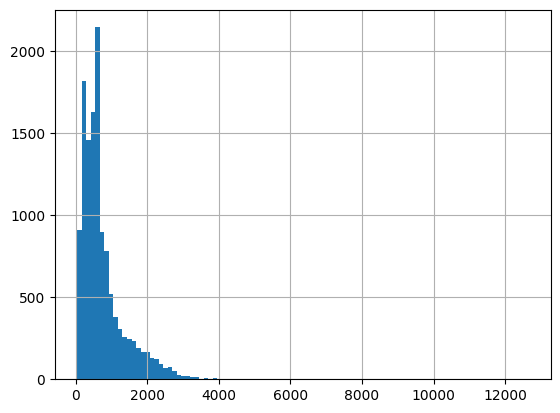

In [4]:
dataset['train'].to_pandas().loc[:12800, 'text'].apply(lambda x: len(x.split())).hist(bins=100)

In [ ]:
bins = [0, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
pd.cut(dataset['train'].to_pandas().loc[:1000, 'text'].apply(lambda x: len(x.split())), bins=bins, include_lowest=True).value_counts()

text
(512.0, 1024.0]      392
(256.0, 512.0]       244
(1024.0, 2048.0]     156
(128.0, 256.0]       141
(2048.0, 4096.0]      43
(-0.001, 128.0]       20
(4096.0, 8192.0]       4
(8192.0, 16384.0]      1
Name: count, dtype: int64

In [18]:
from transformers import AutoTokenizer
# get the first 20000 examples
fset = dataset["train"].select(range(12800))
tokenizer = AutoTokenizer.from_pretrained('alehc/swissai-tokenizer')

In [19]:
# from transformers import AutoTokenizer
# # get the first 20000 examples
# subset = dataset["train"].select(range(12800))
# tokenizer = AutoTokenizer.from_pretrained('alehc/swissai-tokenizer')

def split_example(examples, input_size=128, max_tokens=4096):
    # text = example['text']
    # tokens = tokenizer.tokenize(text)
    # input = tokenizer.convert_tokens_to_string(tokens[:input_size])
    # target = tokenizer.convert_tokens_to_string(tokens[input_size:max_tokens])
    # return {'input_text': input, 'target_text': target}
    input_texts = []
    target_texts = []
    
    for i, text in enumerate(examples['text']):
        tokens = tokenizer.tokenize(text)
        input = tokenizer.convert_tokens_to_string(tokens[:input_size])
        target = tokenizer.convert_tokens_to_string(tokens[input_size:max_tokens])
        input_texts.append(input)
        target_texts.append(target)
    
    return {'input_text': input_texts, 'target_text': target_texts}

subset = fset.map(split_example, batched=True)


In [20]:
positive_examples = subset.filter(lambda example: len(example['target_text']) != 0)

In [21]:
positive_examples

Dataset({
    features: ['text', 'id', 'metadata', 'input_text', 'target_text'],
    num_rows: 12653
})

In [ ]:
# # save the dataset
# positive_examples.save_to_disk('/iopsstor/scratch/cscs/ansaripo/data/nytimes_verbatim')

Saving the dataset (1/1 shards): 100%|██████████| 12653/12653 [00:00<00:00, 31417.12 examples/s]


In [11]:
#login to huggingface
!transform
!transformers-cli login

/usr/local/bin/bash: transform: command not found
Traceback (most recent call last):
  File "/users/ansaripo/miniconda3/envs/robots/bin/transformers-cli", line 5, in <module>
    from transformers.commands.transformers_cli import main
  File "/users/ansaripo/miniconda3/envs/robots/lib/python3.10/site-packages/transformers/commands/transformers_cli.py", line 20, in <module>
    from .chat import ChatCommand
  File "/users/ansaripo/miniconda3/envs/robots/lib/python3.10/site-packages/transformers/commands/chat.py", line 29, in <module>
    from rich.console import Console
ModuleNotFoundError: No module named 'rich'


In [ ]:
# push the dataset to the hub
from datasets import Dataset, DatasetDict

from huggingface_hub import login
DatasetDict({'test': positive_examples}).push_to_hub('nytimes_verbatim')

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained('mistralai/Mistral-Nemo-Base-2407')

In [24]:
load_dataset("mansaripo/nytimes_verbatim")

Generating test split: 100%|██████████| 12653/12653 [00:00<00:00, 57455.53 examples/s]


DatasetDict({
    test: Dataset({
        features: ['text', 'id', 'metadata', 'input_text', 'target_text'],
        num_rows: 12653
    })
})

In [25]:
load_dataset("wikitext", "wikitext-2-raw-v1")

Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 434678.84 examples/s]


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [12]:
import json
from datasets import Dataset, DatasetDict

data_json = "/iopsstor/scratch/cscs/ansaripo/deepseek_questions.json"
questions = json.load(open(data_json, "r"))

qs = []
for q in questions:
    qs.append(q['generated_question'])

# convert to hf dataset
dataset = Dataset.from_list(qs)

In [13]:
DatasetDict({'test': dataset}).push_to_hub('nytimes_completion')

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/mansaripo/nytimes_completion/commit/3c76a1cfe47d093647fb4945618e307c9356d84e', commit_message='Upload dataset', commit_description='', oid='3c76a1cfe47d093647fb4945618e307c9356d84e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mansaripo/nytimes_completion', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mansaripo/nytimes_completion'), pr_revision=None, pr_num=None)

In [ ]:
DatasetDict({'test': Dataset.from_list([q['generated_question'] for q in questions])}).push_to_hub('nytimes_completion')